In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from scipy import optimize

def linear(p,x):
    return p[0]*x + p[1]

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    
    # The code below defines our data fitting function.
    # Inputs are:
    # initial guess for parameters p0
    # the function we're fitting to
    # the x,y, and dy variables
    # tmi can be set to 1 or 2 if more intermediate data is needed

    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:", error)
        return p0, np.zeros_like(p0), np.nan, np.nan
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), np.nan, np.nan
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

## Data

In [7]:
data = pd.read_csv('./data/3.csv')

fps = 8810
dropoff_frame = 1204
frames_till_dropoff = (dropoff_frame - data['frame'])
times_till_dropoff = frames_till_dropoff/fps

diameters = data['width']

diameters_err = data['width_err']

## Checkpoint 3

Text(0.5, 1.0, 'Pinch Drop-off')

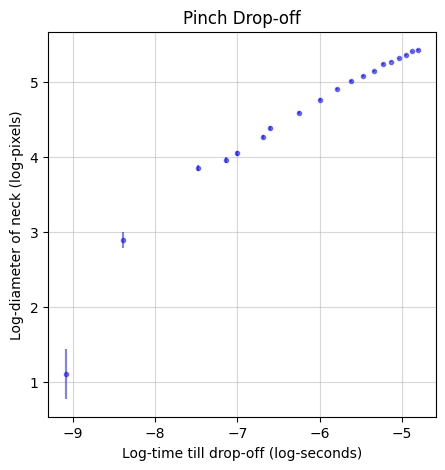

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.errorbar(
    np.log(times_till_dropoff), np.log(diameters), yerr=diameters_err/diameters, 
    color='blue', 
    alpha=0.5,
    fmt='.'
)

ax.set_xlabel('Log-time till drop-off (log-seconds)')
ax.set_ylabel('Log-diameter of neck (log-pixels)')
ax.grid(alpha=0.5)
ax.set_title('Pinch Drop-off')

In [12]:
fit_lower, fit_upper = 10, 20
x = np.log(times_till_dropoff)[fit_lower:fit_upper].to_numpy()
y = np.log(diameters)[fit_lower:fit_upper].to_numpy()
y_err = (diameters_err/diameters)[fit_lower:fit_upper].to_numpy()

params_0 = [1, 10]

params, params_err, chisq, dof = data_fit(params_0, linear, x, y, y_err)


Converged with chi-squared 34.80
Number of degrees of freedom, dof = 7.00
Reduced chi-squared 4.97

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.000e+00                | 7.004e-01                | 2.028e-02               
1           | 1.000e+01                | 8.967e+00                | 1.315e-01               


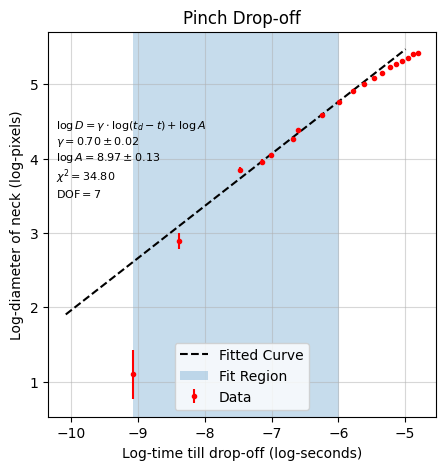

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.errorbar(
    np.log(times_till_dropoff), np.log(diameters), diameters_err/diameters, 
    color='red', 
    fmt='.', 
    label='Data'
)

linspace = np.linspace(x.min()-1, x.max()+1)
ax.plot(linspace, linear(params, linspace), color='black', linestyle='dashed', label='Fitted Curve')

ax.axvspan(x[-1], x[0], alpha=0.25, label='Fit Region')

txt = '$\\log D = \\gamma \\cdot \\log (t_d - t) + \\log A$ \n'
txt += f'$\\gamma = {params[0]:.2f} \\pm {params_err[0]:.2f}$ \n'
txt += f'$\\log A = {params[1]:.2f} \\pm {params_err[1]:.2f}$ \n'
txt += f'$\\chi^2 = {chisq:.2f}$ \n'
txt += f'DOF$ = {dof}$'
ax.text(0.02, 0.775, txt, transform=ax.transAxes , fontsize=8, va='top')

ax.grid(alpha=0.5)
ax.set_xlabel('Log-time till drop-off (log-seconds)')
ax.set_ylabel('Log-diameter of neck (log-pixels)')
ax.set_title('Pinch Drop-off')
ax.legend()